In [289]:
import numpy as np # linear algebra
import pandas as pd # data manipulation and analysis
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization
sns.set_style('whitegrid') # set style for visualization
import warnings # ignore warnings
warnings.filterwarnings('ignore')
import requests, zipfile, io
import plotly.express as px

# Import Dataset and Load to Pandas

In [290]:
# Download and Unzip the Dataset
url = "https://github.com/devtlv/Datasets-DA-Bootcamp-2-/raw/refs/heads/main/Week%207%20-%20Analysing%20Web%20Data/W7D3%20-%20Mini%20project/Global%20Terrorism%20Database.zip"

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("data")

In [291]:
# Load to Pandas as Dataframe
df = pd.read_csv(r'C:\Repositories\DI-Bootcamp\Week13\Day5\data\Global Terrorism Database\Global Terrorism Database\globalterrorismdb_0718dist.csv', encoding='latin1')

# Basic Overview
print(df.shape)
print(df.head())
print('=' * 75)

pd.options.display.max_info_columns = 200

print(df.info())

(181691, 135)
        eventid  iyear  imonth  iday approxdate  extended resolution  country  \
0  197000000001   1970       7     2        NaN         0        NaN       58   
1  197000000002   1970       0     0        NaN         0        NaN      130   
2  197001000001   1970       1     0        NaN         0        NaN      160   
3  197001000002   1970       1     0        NaN         0        NaN       78   
4  197001000003   1970       1     0        NaN         0        NaN      101   

          country_txt  region                   region_txt provstate  \
0  Dominican Republic       2  Central America & Caribbean       NaN   
1              Mexico       1                North America   Federal   
2         Philippines       5               Southeast Asia    Tarlac   
3              Greece       8               Western Europe    Attica   
4               Japan       4                    East Asia   Fukouka   

            city   latitude   longitude  specificity  vicinity loc

# Cleaning

In [292]:
# Check For Duplicates
print("Number of Duplicates:", df.duplicated().sum())

Number of Duplicates: 0


## Drop Unecessary Columns

In [293]:
# columns to keep 
# - iyear, imonth, iday, extended, crit1, crit2, crit3, doubtterr (impute 1 miss value with mode)
# - multiple (impute with mode 1 miss value), country, country_txt, region, region_txt, attacktype1, attacktype1_txt,
# - success, suicide, weaptype1, weaptype1_txt, targtype1, targtype1_txt
# - targsubtype1; targsubtype1_txt (impute Null as Unknown), 
# - natlty1, natlty1_txt (impute null with unknown), gname, guncertain1 (impute null values with mode), individual
# - nperps (impute -99 as unknown, and null as unknown), claimed (impute null as '0')
# - nkill (impute nulls as unknown), nwound (impute nulls as unknown), property 
# - propextent (impute nulls as 4.0 that's categorized as unknown), propextent_txt (impute null as Unknown (4.0))
# - ishostkid (impute nulls with -9.0), INT_LOG, INT_IDEO, INT_MISC, INT_ANY 

# Columns to keep in the dataframe
columns_keep =  ['iyear', 'imonth', 'iday', 'doubtterr', 'extended', 'crit1', 'crit2', 'crit3', 'multiple', 'country_txt', 'region_txt',
                 'attacktype1_txt', 'success', 'suicide', 'weaptype1_txt', 'targtype1_txt',
                 'targsubtype1_txt', 'natlty1_txt', 'gname', 'guncertain1', 'individual', 'nperps', 'claimed', 'nkill',
                 'nwound', 'property', 'propextent_txt', 'ishostkid', 'INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY']

# Update DF with relevant columns
df = df[columns_keep]

# Check
print(df.shape)

(181691, 32)


## Handle Missing Values and Inconsistencies

In [294]:
# Quick Glance at Columns with Missing Values
print(df.isna().sum().sort_values(ascending=False))

propextent_txt      117626
nperps               71115
claimed              66120
nwound               16311
targsubtype1_txt     10373
nkill                10313
natlty1_txt           1559
guncertain1            380
ishostkid              178
doubtterr                1
multiple                 1
imonth                   0
extended                 0
crit1                    0
crit2                    0
iyear                    0
targtype1_txt            0
weaptype1_txt            0
suicide                  0
success                  0
attacktype1_txt          0
region_txt               0
country_txt              0
crit3                    0
iday                     0
gname                    0
individual               0
property                 0
INT_LOG                  0
INT_IDEO                 0
INT_MISC                 0
INT_ANY                  0
dtype: int64


#### Date Columns

In [295]:
# Change Months/Days Where the Value is 0 to 1
df['imonth'] = df['imonth'].replace(0, 1)
df['iday'] = df['iday'].replace(0, 1)

# Create a Date Column From the iyear/imonth/iday Columns
df['date'] = pd.to_datetime(df['iyear'].astype(str) + '-' + df['imonth'].astype(str) + '-' + df['iday'].astype(str))

# Drop Unnecessary Columns
df = df.drop(columns=['iyear', 'imonth', 'iday'])

# Check
df.shape

(181691, 30)

#### Simple Fills 
These Columns Don't Require Much Preprocessing (Fill Nulls with the Column's Mode)

In [296]:
# Multiple Column - Fill NA's with Mode
df['multiple'] = df['multiple'].fillna(df['multiple'].mode()[0])
df['multiple'] = df['multiple'].astype(int)

# guncertain1 Column - Fill NA's with Mode
df['guncertain1'] = df['guncertain1'].fillna(df['guncertain1'].mode()[0])
df['guncertain1'] = df['guncertain1'].astype(int)

# Nationality Columns
df['natlty1_txt'] = df['natlty1_txt'].fillna('Unknown')

# Target Subtype Columns - Fill Nulls with Mode
df['targsubtype1_txt'] = df['targsubtype1_txt'].fillna(df['targsubtype1_txt'].mode()[0])

# Propextent Column - We have an unkown value (4), so we can change the nulls to unknown
df['propextent_txt'] = df['propextent_txt'].fillna('Unknown')

In [297]:
# Certain Columns Have -9 Instead of Null
cols = ['INT_LOG', 'INT_IDEO', 'INT_MISC', 'INT_ANY', 'property', 'doubtterr', 'ishostkid', 'claimed']

# For These Columns we want to Convert -9 to Null and then Fill
for col in cols:
    df[col].replace(-9, np.nan, inplace=True) # Replace -9 with Null
    df[col] = df[col].fillna(df[col].mode()[0]) # Fill Null Values with Column Mode
    df[col] = df[col].astype(int)

#### Complex Fills

In [298]:
# Nperps, NKills, NWound are our Target Numerical Columns
cols = ['nperps', 'nkill', 'nwound']

for col in cols:
    # Step 1: Replace unknown values (-99) with NaN
    df[col].replace(-99.0, np.nan, inplace=True)

    # Step 2: Group by Desired Features and Fill Nulls Using Median
    df[col] = df.groupby(['attacktype1_txt', 'region_txt'])[col].transform(
        lambda x: x.fillna(x.median())
    )
    # Step 3: Fill any remaining NaNs with overall median
    df[col] = df[col].fillna(df[col].median())

    # Convert Column to Int
    df[col] = df[col].astype(int)

In [299]:
# Final Check
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181691 entries, 0 to 181690
Data columns (total 30 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   doubtterr         181691 non-null  int64         
 1   extended          181691 non-null  int64         
 2   crit1             181691 non-null  int64         
 3   crit2             181691 non-null  int64         
 4   crit3             181691 non-null  int64         
 5   multiple          181691 non-null  int64         
 6   country_txt       181691 non-null  object        
 7   region_txt        181691 non-null  object        
 8   attacktype1_txt   181691 non-null  object        
 9   success           181691 non-null  int64         
 10  suicide           181691 non-null  int64         
 11  weaptype1_txt     181691 non-null  object        
 12  targtype1_txt     181691 non-null  object        
 13  targsubtype1_txt  181691 non-null  object        
 14  natl

In [300]:
pd.set_option('display.max_columns', None)
df.head()

doubtterr  extended  crit1  crit2  crit3  multiple         country_txt  \
0          0         0      1      1      1         0  Dominican Republic   
1          0         0      1      1      1         0              Mexico   
2          0         0      1      1      1         0         Philippines   
3          0         0      1      1      1         0              Greece   
4          0         0      1      1      1         0               Japan   

                    region_txt                 attacktype1_txt  success  \
0  Central America & Caribbean                   Assassination        1   
1                North America     Hostage Taking (Kidnapping)        1   
2               Southeast Asia                   Assassination        1   
3               Western Europe               Bombing/Explosion        1   
4                    East Asia  Facility/Infrastructure Attack        1   

   suicide weaptype1_txt                targtype1_txt  \
0        0       Unknown  Private Citizens & Property   
1        0       Unknown      Government (Diplomatic)   
2        0       Unknown          Journalists & Media   
3        0    Explosives      Government (Diplomatic)   
4        0    Incendiary      Government (Diplomatic)   

                                    targsubtype1_txt         natlty1_txt  \
0                                     Named Civilian  Dominican Republic   
1  Diplomatic Personnel (outside of embassy, cons...             Belgium   
2                    Radio Journalist/Staff/Facility       United States   
3                                  Embassy/Consulate       United States   
4                                  Embassy/Consulate       United States   

                                gname  guncertain1  individual  nperps  \
0                              MANO-D            0           0       3   
1  23rd of September Communist League            0           0       7   
2                             Unknown            0           0       2   
3                             Unknown            0           0       2   
4                             Unknown            0           0       1   

   claimed  nkill  nwound  property propextent_txt  ishostkid  INT_LOG  \
0        0      1       0         0        Unknown          0        0   
1        0      0       0         0        Unknown          1        0   
2        0      1       0         0        Unknown          0        0   
3        0      0       0         1        Unknown          0        0   
4        0      0       0         1        Unknown          0        0   

   INT_IDEO  INT_MISC  INT_ANY       date  
0         0         0        0 1970-07-02  
1         1         1        1 1970-01-01  
2         0         1        1 1970-01-01  
3         0         1        1 1970-01-01  
4         0         1        1 1970-01-01

# Data Preprocessing

In [301]:
# Quick Look at Numerical Columns
df.describe()

doubtterr       extended          crit1          crit2  \
count  181691.000000  181691.000000  181691.000000  181691.000000   
mean        0.159617       0.045346       0.988530       0.993093   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       1.000000       1.000000   
50%         0.000000       0.000000       1.000000       1.000000   
75%         0.000000       0.000000       1.000000       1.000000   
max         1.000000       1.000000       1.000000       1.000000   
std         0.366252       0.208063       0.106483       0.082823   

               crit3       multiple        success        suicide  \
count  181691.000000  181691.000000  181691.000000  181691.000000   
mean        0.875668       0.137772       0.889598       0.036507   
min         0.000000       0.000000       0.000000       0.000000   
25%         1.000000       0.000000       1.000000       0.000000   
50%         1.000000       0.000000       1.000000       0.000000   
75%         1.000000       0.000000       1.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   
std         0.329961       0.344662       0.313391       0.187549   

        guncertain1     individual         nperps        claimed  \
count  181691.00000  181691.000000  181691.000000  181691.000000   
mean        0.08127       0.002950       9.190213       0.104606   
min         0.00000       0.000000      -9.000000       0.000000   
25%         0.00000       0.000000       1.000000       0.000000   
50%         0.00000       0.000000       2.000000       0.000000   
75%         0.00000       0.000000       4.000000       0.000000   
max         1.00000       1.000000   25000.000000       1.000000   
std         0.27325       0.054234     163.366825       0.306046   

               nkill         nwound       property      ishostkid  \
count  181691.000000  181691.000000  181691.000000  181691.000000   
mean        2.304313       2.900991       0.632497       0.074698   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       1.000000       0.000000   
75%         2.000000       2.000000       1.000000       0.000000   
max      1570.000000    8191.000000       1.000000       1.000000   
std        11.222434      34.308763       0.482126       0.262905   

             INT_LOG       INT_IDEO       INT_MISC        INT_ANY  \
count  181691.000000  181691.000000  181691.000000  181691.000000   
mean        0.039562       0.125433       0.114133       0.206537   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   
std         0.194928       0.331210       0.317974       0.404822   

                                date  
count                         181691  
mean   2003-02-18 11:32:29.188457472  
min              1970-01-01 00:00:00  
25%              1991-02-06 00:00:00  
50%              2009-02-22 00:00:00  
75%              2014-08-09 00:00:00  
max              2017-12-31 00:00:00  
std                              NaN

## Scaling/Standardizing Numerical Columns

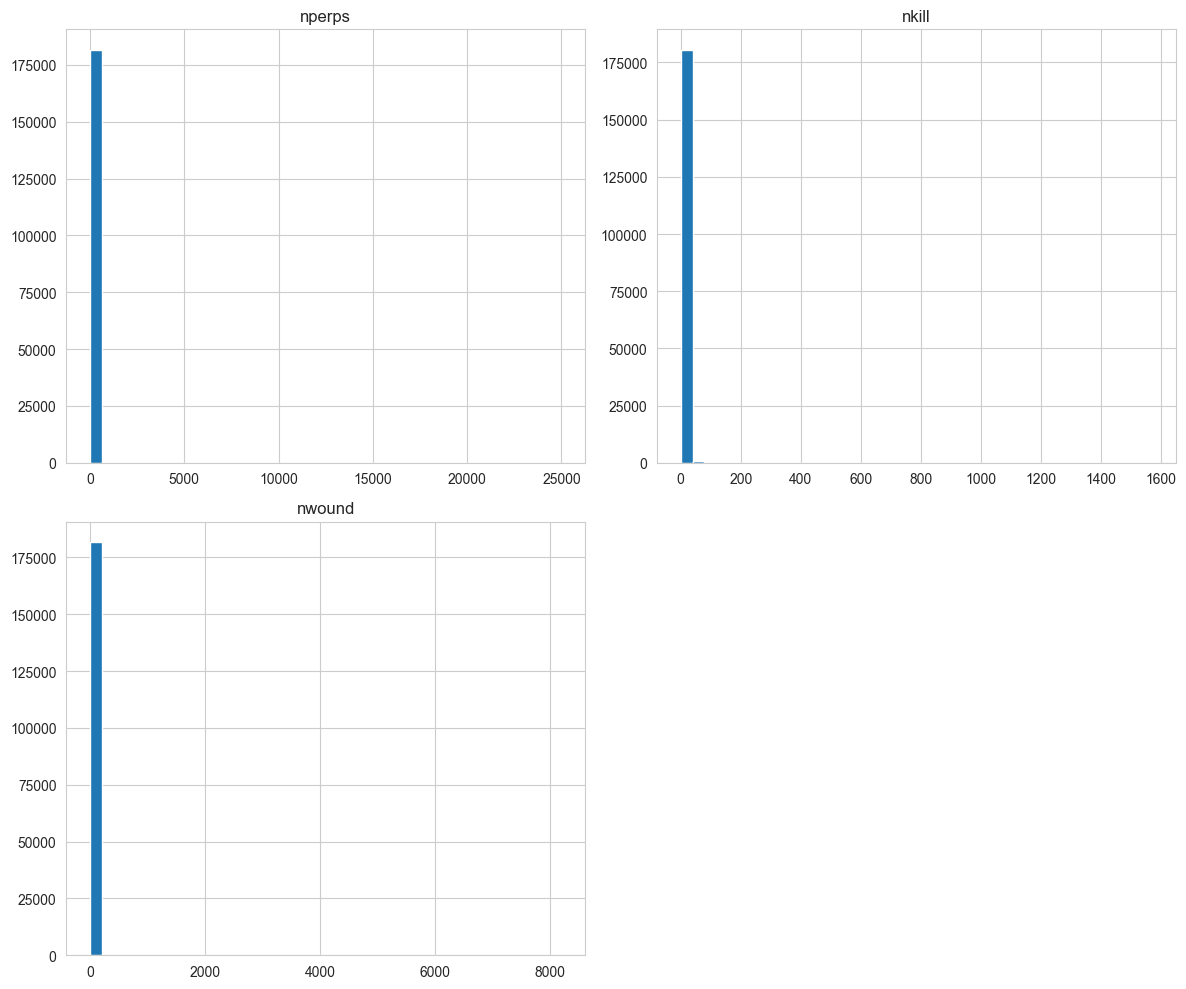

In [302]:
# numerical columns - standardize (check which method to apply after checking dist)

# nperps, nkill, nwound
num_columns = df[['nperps', 'nkill', 'nwound']]

# Distribution of numerical columns 
num_columns.hist(bins=40,figsize=(12, 10))
plt.tight_layout()
plt.show()

In [303]:
from sklearn.preprocessing import RobustScaler

# Specify Columns to Scale
cols_to_scale = ['nperps', 'nkill', 'nwound']

# Initialize the scaler
scaler = RobustScaler()

# Fit and transform the selected columns
scaled_values = scaler.fit_transform(df[cols_to_scale])

# Create new columns with standardized values
scaled_col_names = [col + '_scaled' for col in cols_to_scale]
df[scaled_col_names] = scaled_values

## One-Hot Encoding For Categorical Columns

In [304]:
# Determine Categorical Columns for Encoding
categorical_cols = df.select_dtypes(exclude=['number', 'datetime64']).columns

# Apply one-hot encoding using pandas
encoded_df = pd.get_dummies(df[categorical_cols], 
                            prefix=categorical_cols, 
                            dtype=int)

# Concatenate the new encoded columns to the original DataFrame
df = pd.concat([df, encoded_df], axis=1)

# Exploratory Data Analysis

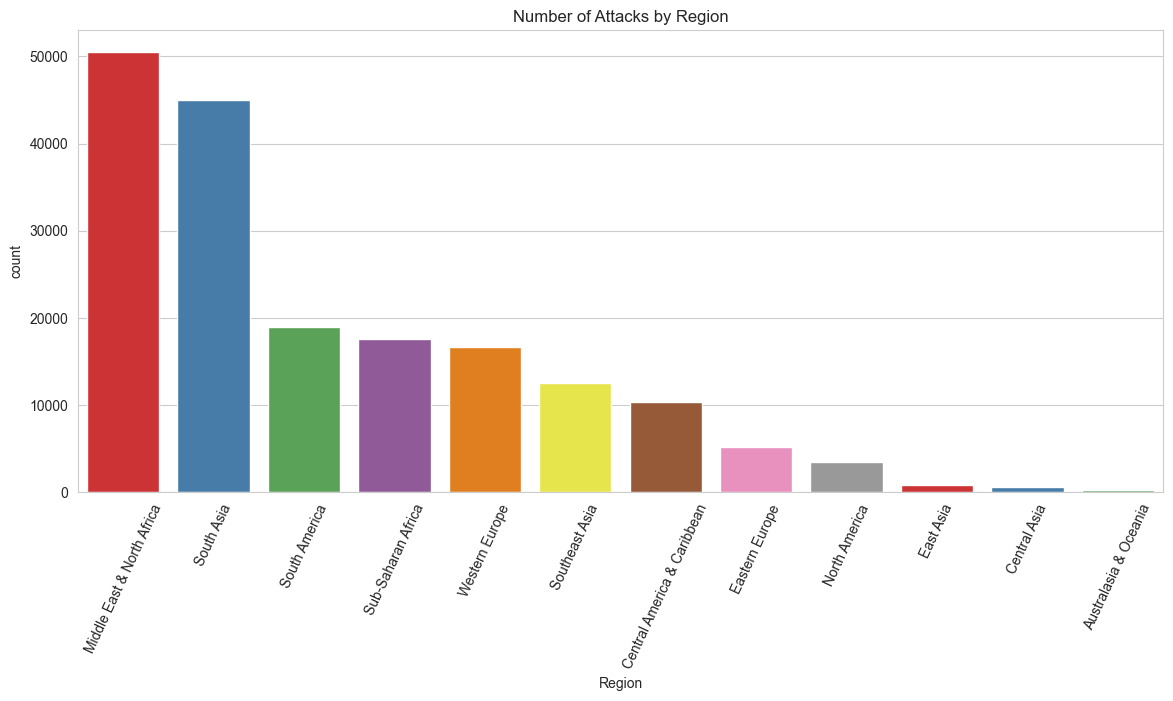

In [305]:
# Attacks Per Region

# To Ensure that the Data is in Order
region_order = df['region_txt'].value_counts().index

plt.figure(figsize=(14,6))
sns.countplot(data=df, x='region_txt', palette='Set1', order=region_order)
plt.title("Number of Attacks by Region")
plt.xlabel("Region")
plt.xticks(rotation=65)
plt.show()

In [306]:
# Number of people killed by region 
fig = px.pie(df, values='nkill', names='region_txt', title='Number of People Killed - Distribution By Region')
fig.show()

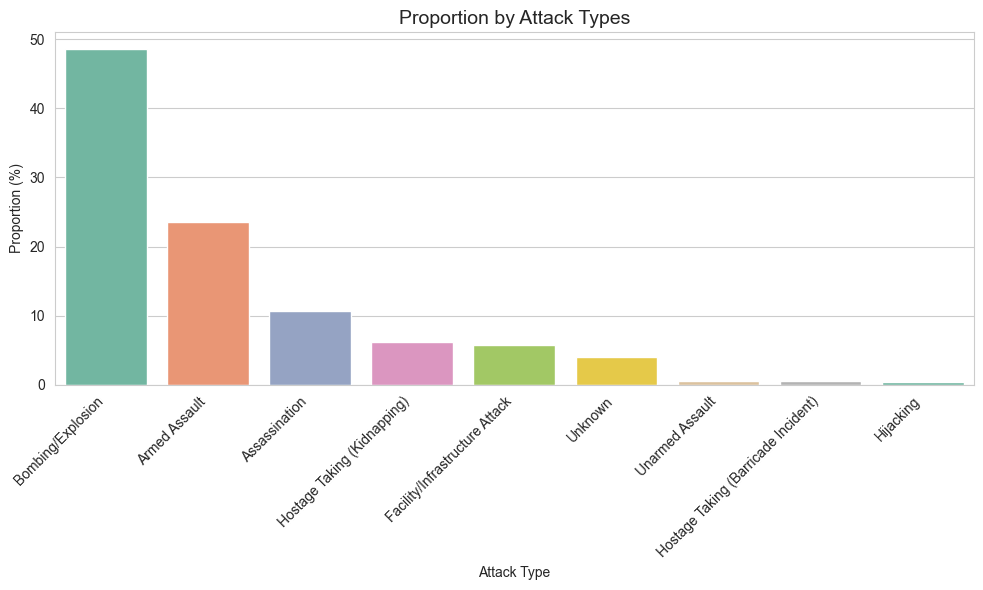

In [307]:
# Proportion by Attack Type
attack_perc = (
    df['attacktype1_txt']
    .value_counts(normalize=True)
    .mul(100)
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=attack_perc, x='attacktype1_txt', y='proportion', palette='Set2')
plt.title("Proportion by Attack Types", fontsize=14)
plt.ylabel("Proportion (%)")
plt.xlabel("Attack Type")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [308]:
# Series of people killed over time 

# Create a new column with year from date column
df['year'] = df['date'].dt.year 

# Ensure date column is datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['year'] = df['date'].dt.year

# Create wounded categories
bins = [0, 1, 5, 20, 1000]
labels = ['0', '1-5', '6-20', '21+']
df['nwound_cat'] = pd.cut(df['nwound'].replace(-9, pd.NA).fillna(0), bins=bins, labels=labels)

# Aggregate counts
agg_df = df.groupby(['year', 'nwound_cat']).size().reset_index(name='count')

# Plot
fig = px.bar(
    agg_df,
    x='year',
    y='count',
    color='nwound_cat',
    title='Terrorist Attacks per Year by Number of Wounded',
    labels={'count': 'Number of Attacks', 'nwound_cat': 'Number of Wounded'},
    barmode='stack',
    width=1200,
    height=600
)
fig.show()